In [71]:
from thirdparty.dts.deepseries.model.rnn2rnn import RNN2RNN
from thirdparty.dts.deepseries.train import Learner
from thirdparty.dts.deepseries.data import Value, create_seq2seq_data_loader_array, forward_split
from thirdparty.dts.deepseries.nn import RMSE, MSE
import thirdparty.dts.deepseries.functional as F
import numpy as np
import torch
import matplotlib.pyplot as plt

from utils.data import *

In [72]:
batch_size = 1
enc_len = 128
dec_len = 32
lr=1e-3
num_assets = 2

In [73]:
prices, _ = get_data("data/data.csv", 'cuda')

prices = prices.unsqueeze(0).tile((batch_size, 1, 1)).permute((0, 2, 1)).cpu().numpy()
train_idx = int(prices.shape[-1] * 0.8)
prices.shape

Reading data from file data/data.csv
========== Data Loaded ==========
                btc   gold_inter
count   1826.000000  1826.000000
mean   12206.068281  1463.644496
std    14043.891627   249.329936
min      594.080000  1125.700000
25%     3994.982500  1266.050000
50%     7924.460000  1327.825000
75%    11084.730000  1724.150000
max    63554.440000  2067.150000
Totally 1826 days of trade, with 571 unavailable for gold.
========== Data Loaded ==========


(1, 2, 1826)

In [74]:
train_dl = create_seq2seq_data_loader_array(prices[:, :, :train_idx], enc_len, dec_len, sampling_rate=0.1,
                                            batch_size=batch_size, seq_last=True, device='cuda')
valid_dl = create_seq2seq_data_loader_array(prices[:, :, train_idx:], enc_len, dec_len,
                                            batch_size=batch_size, seq_last=True, device='cuda')

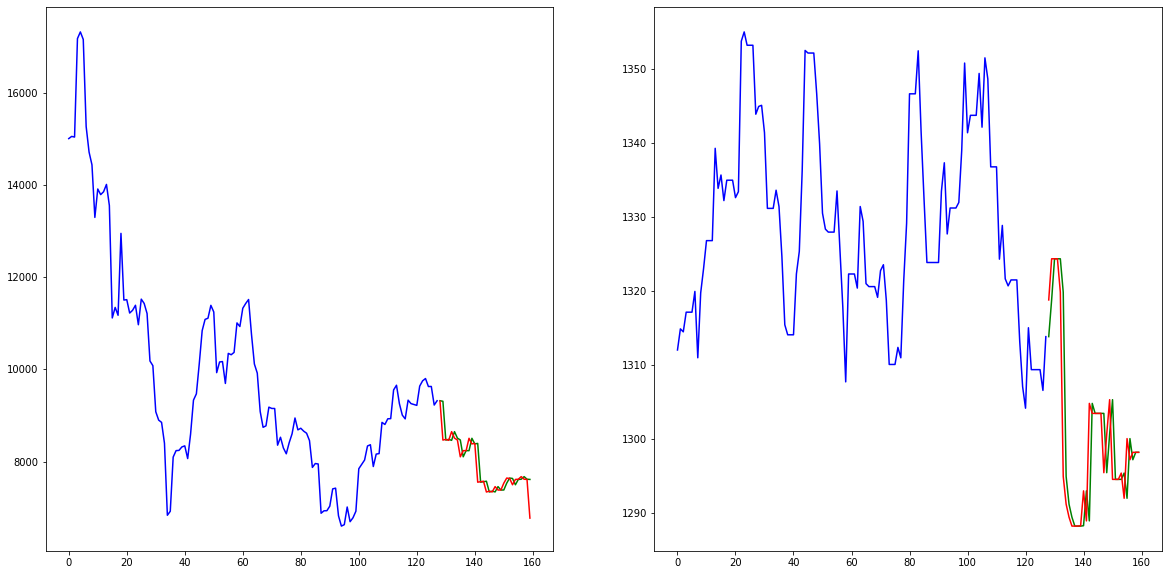

In [75]:
for idx, data in enumerate(train_dl):
    enc_xx = np.arange(enc_len)
    dec_xx = np.arange(enc_len, enc_len + dec_len)
    if idx == 0:
        plt.figure(figsize=(20, 10))
        for j in range(num_assets):
            plt.subplot(1, 2, j+1)
            # print(data[1].shape, (data[0]['dec_x'].shape))
            
            plt.plot(enc_xx, data[0]['enc_x'][0, j].detach().cpu(), color='blue')
            plt.plot(dec_xx, data[0]['dec_x'][0, j].detach().cpu(), color='green')
            plt.plot(dec_xx, data[1][0, j].detach().cpu(), color='red')

In [79]:
model = RNN2RNN(enc_len, dec_len, 32).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
wave_learner = Learner(model, optimizer, root_dir="data/predict/dts/wave")

/home/yuyang/anaconda3/envs/trading/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [80]:
wave_learner.fit(100, train_dl, valid_dl, early_stopping=True, patient=16)

[[02/20/2022 08:21:49]] start training >>>>>>>>>>>  see log: tensorboard --logdir data/predict/dts/wave/logs


RuntimeError: input.size(-1) must be equal to input_size. Expected 128, got 32